In [ ]:
############ Necessary labraries#############
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision.datasets import CIFAR100
from torchvision import transforms
from time import time
from skimage.data import astronaut,rocket
from skimage.metrics import structural_similarity
from torch.nn.modules.pooling import MaxPool2d
from torchviz import make_dot
device = ('cuda' if torch.cuda.is_available() else 'cpu')
!pip install torchmetrics
from torchmetrics import StructuralSimilarityIndexMeasure

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 16.9 MB/s 


In [ ]:
############ Required transformations on dataset #############
mytransforms = transforms.Compose([
                                   transforms.ToTensor()])

In [ ]:
############ Downloading Dataset #############
train_data = CIFAR100('./data', download = True, train = True, transform=mytransforms)
test_data  = CIFAR100('./data', download = False, train = False, transform=mytransforms)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data


In [ ]:
print(train_data)

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [ ]:
############ Providing Dataloaders for train and test data #############
train_loader = DataLoader(train_data, batch_size = 16, num_workers = 1)
test_loader = DataLoader(test_data, batch_size = 16, num_workers = 1)

In [ ]:
############ Defining classes which are used in Network #############

############ DenseNet is composed of Single layers  #############
class SingleLayer(nn.Module):
    def __init__(self, nChannels, growthRate):
        super(SingleLayer, self).__init__()
        self.bn     = nn.BatchNorm2d(nChannels)
        self.conv   = nn.Conv2d(nChannels, growthRate, kernel_size=3,padding=1, bias=False)
        self.relu   = nn.ReLU()
        self.dropout = nn.Dropout2d(0.2)

    def forward(self, x):
        out = self.bn(x)
        out = self.conv(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = torch.cat((x, out), 1)
        return out
        
####################################################################################################

############ DenseNet is made by choosing number of layers and growth rate which is a constant output of each layer  #############

class DenseNet(nn.Module):
  def __init__(self, nChannels, growthRate, nDenseBlocks):
    super(DenseNet,self).__init__()
    self.dense = self.make_dense(nChannels, growthRate, nDenseBlocks)
  
  def make_dense(self, nChannels, growthRate, nDenseBlocks):
    layers = []
    for i in range(int(nDenseBlocks)):
        layers.append(SingleLayer(nChannels, growthRate))
        nChannels += growthRate
    return nn.Sequential(*layers)  

  def forward(self,x):
    out = self.dense(x)
    return out


####################################################################################################

############ Transition down layer is used to reduce the number of feature maps  #############
class Transition_Down(nn.Module): 
  def __init__(self, input_channels,output_channels):
    super(Transition_Down, self).__init__()
    self.TD = nn.Sequential(nn.BatchNorm2d(input_channels),
                            nn.ReLU(),
                            nn.Conv2d(input_channels,output_channels,kernel_size=1,padding ='same'),
                            nn.MaxPool2d(kernel_size=2,stride=2))
    
  def forward(self,x):
    out = self.TD(x)
    return out  
    
####################################################################################################

############ Transition up layer is used to compensate the effect of transtion down layer which has reduce nemuber of feature maps  #############
class Transition_Up(nn.Module): 
  def __init__(self, input_channels,output_channels):
    super(Transition_Up, self).__init__()
    self.TU = nn.ConvTranspose2d(input_channels,output_channels, kernel_size=2, stride=2 , padding=0)
    
  def forward(self,x):
    out = self.TU(x)
    return out  
    
####################################################################################################

############ Decoder block is used in reveal network ro extract secret image #############
class Decoder_block(nn.Module): 
  def __init__(self, input_channels , output_channels):
    super(Decoder_block, self).__init__()
    self.DB = nn.Sequential(nn.Conv2d(input_channels , output_channels , kernel_size=3 , padding =1 ,stride=1),
                            nn.BatchNorm2d(output_channels),
                            nn.ReLU())
    
  def forward(self,x):
    out = self.DB(x)
    return out      
    

In [ ]:
############ Defining Hidden Network by using the classes which are defined previously #############
class Hidden_Network(nn.Module):
  def __init__(self):
    super(Hidden_Network,self).__init__()
    self.conv1 = nn.Conv2d( 6, 48, kernel_size = 3 , padding = 'same')
    self.DB1   = DenseNet (48,12,4)
    self.TD1   = Transition_Down(144,96)
    self.DB2   = DenseNet (96,12,4)
    self.TD2   = Transition_Down(240,144)
    self.DB3   = DenseNet (144,12,4)
    self.TD3   = Transition_Down(336,192)
    self.DB4   = DenseNet (192,12,4)
    self.TU1   = Transition_Up (240,60)
    self.DB5   = DenseNet (396,12,4)
    self.TU2   = Transition_Up (444,100)
    self.DB6   = DenseNet (340,12,4)
    self.TU3   = Transition_Up (388,88)
    self.DB7   = DenseNet (232,12,4)
    self.conv2 = nn.Conv2d( 280, 3, kernel_size = 3 , padding = 'same')
  def forward(self, input):
    y   = self.conv1(input)
    DB1 = self.DB1(y)
    C1  = torch.cat((y, DB1), 1)
    TD1 = self.TD1(C1)
    DB2 = self.DB2(TD1)
    C2  = torch.cat((DB2, TD1), 1)
    TD2 = self.TD2(C2)
    DB3 = self.DB3(TD2)
    C3  = torch.cat((DB3, TD2), 1)
    TD3 = self.TD3(C3)
    DB4 = self.DB4(TD3)
    TU1 = self.TU1(DB4)
    C4  = torch.cat((TU1, C3), 1)
    DB5 = self.DB5(C4)
    TU2 = self.TU2(DB5)
    C5  = torch.cat((TU2, C2), 1)
    DB6 = self.DB6(C5)
    TU3 = self.TU3(DB6)
    C6  = torch.cat((TU3, C1), 1)
    DB7 = self.DB7(C6)
    output = self.conv2(DB7)
    return output

In [ ]:
########## Testing the Hidden Network ###########
a = torch.rand(2,6,32,32)
Hidden_Network().forward(a).shape

torch.Size([2, 3, 32, 32])

In [ ]:
############ Defining Reveal Network by using the classes which are defined previously #############

class Reveal_Network(nn.Module):

  def __init__(self):
    super(Reveal_Network,self).__init__()
    self.Decoder1 = Decoder_block(3,32)
    self.Decoder2 = Decoder_block(32,64)
    self.Decoder3 = Decoder_block(64,128)
    self.Decoder4 = Decoder_block(128,256)
    self.Decoder5 = Decoder_block(256,128)
    self.Decoder6 = Decoder_block(128,64)
    self.Decoder7 = Decoder_block(64,32)
    self.conv1    = nn.Conv2d( 32 , 3 , kernel_size=3 , padding =1 ,stride=1)
    self.sigmo    = nn.Sigmoid()

  def forward(self, input):
    Decoder1  = self.Decoder1(input)
    Decoder2  = self.Decoder2(Decoder1)
    Decoder3  = self.Decoder3(Decoder2)
    Decoder4  = self.Decoder4(Decoder3)
    Decoder5  = self.Decoder5(Decoder4)
    Decoder6  = self.Decoder6(Decoder5)
    Decoder7  = self.Decoder7(Decoder6)
    output    = self.sigmo(self.conv1(Decoder7))
    return output

In [ ]:
########## Testing the Reveal Network ###########
a = torch.rand(1,3,256,256)
Reveal_Network().forward(a).shape

torch.Size([1, 3, 256, 256])

In [ ]:
########## Defining Stegano Network which is the complete architecture###########
class Stegano_Network(nn.Module):

  def __init__(self):
    super(Stegano_Network,self).__init__()
    self.hidden=Hidden_Network()
    self.reveal=Reveal_Network()
  def forward(self, input):
    Stego = self.hidden(input)
    revealed_image = self.reveal(Stego)
    
    return Stego,revealed_image

In [ ]:
########## Defining Loss Function classes for each network ###########
########## we used one of quatative evaluation methods (Mean Square Error) to for the loss function ###########
class EncoderLoss(nn.Module):
  def __init__(self):
      super(EncoderLoss,self).__init__()
        
  def forward(self,carrier_image,stego_image):    
      encoder_loss = (F.mse_loss(carrier_image,stego_image))
      return encoder_loss

class DecoderLoss(nn.Module):
  def __init__(self):
      super(DecoderLoss,self).__init__()
        
  def forward(self,revealed_image,secret_image):
      decoder_loss = (F.mse_loss(revealed_image,secret_image))
      return decoder_loss
class SteganoLoss(nn.Module):
  def __init__(self,decoder_weight):
      super(SteganoLoss,self).__init__()
      self.decoder_weight = decoder_weight
        
  def forward(self,carrier_image,stego_image,revealed_image,secret_image):
      stegano_loss = (F.mse_loss(carrier_image,stego_image)) + (self.decoder_weight*(F.mse_loss(revealed_image,secret_image)))
      return stegano_loss     


In [ ]:
mymodel= Stegano_Network()

In [ ]:
########## Transfering model to GPU ###########
mymodel= Stegano_Network().to(device)
Hidden_network= Hidden_Network().to(device)
# Reveal_network= Reveal_Network().to(device)

'''
 DO NOT run this block 
'''
########## Traning loops ###########

epochs = 2    
'''
 The numbers of epochs is small because our dataser has 50000 images so in each epoch our network will be trained by 50000 images, 
 consequently our network will be saturated very soon so this number of epochs is enough 
'''
batch_size=16
beta = 0.75
criterion_encoder=EncoderLoss()
criterion_decoder=DecoderLoss()
criterion = SteganoLoss(beta)   # 0.75 is beta hyperparamete in the paper
opt_hidden = torch.optim.Adam(Hidden_network.parameters())
opt_stegano = torch.optim.Adam(mymodel.parameters())

encoder_losses   = [] # hidden Losses in different epochs
decoder_losses   = [] # reveal Losses in different epochs
losses           = [] # whole network Losses in different epochs
val_losses       = [] # whole network validation losses in different epochs
# carrier=[]
# secret=[]

for epoch in range(epochs):
  for batch_i, (inputs, _) in enumerate(train_loader):
    tic = time() # Start of epoch
    # Train Hidden
    Hidden_network = Hidden_network.train()
    
    batch_losses = []
    encoder_batch_losses = []
    decoder_batch_losses = []
    inputs = inputs.to(device) # Images
    size=inputs.size()
    carrier=torch.empty(int(batch_size/2),size[1],size[2],size[3])
    secret=torch.empty(int(batch_size/2),size[1],size[2],size[3])
    concatenated_input=torch.empty(int(batch_size/2),2*size[1],size[2],size[3])
    j=0
    z=0
    for i in range(len(inputs)):
      if i%2 == 0 : 
        carrier[j]=inputs[i]
        j=j+1
      else :
        secret[z]=inputs[i]
        concatenated_input[z] = torch.cat((carrier[j-1],secret[z]),0)
        z=z+1

    concatenated_input = concatenated_input.to(device)
    carrier=carrier.to(device)
    secret=secret.to(device)
    
    Stego_image = Hidden_network.forward(concatenated_input)
    # encoder_loss=criterion_encoder(carrier,Stego_image)
    # decoder_loss=criterion_decoder(revealed_image,secret)
    opt_hidden.zero_grad()
    opt_stegano.zero_grad()
    loss = criterion_encoder.forward(carrier,Stego_image)
    loss.backward()
    opt_hidden.step()

    """ ---------------------------------------------------------------------------"""

    ##### train stegano
    mymodel = mymodel.train()

    Stego_image,revealed_image = mymodel.forward(concatenated_input)
    encoder_loss=criterion_encoder(carrier,Stego_image)
    decoder_loss=criterion_decoder(revealed_image,secret)
    opt_stegano.zero_grad()
    opt_hidden.zero_grad()
    loss = criterion_decoder.forward(secret,revealed_image)
    loss.backward()
    opt_stegano.step()

    # batch_losses.append(loss.item())
    encoder_batch_losses.append(encoder_loss.item())
    decoder_batch_losses.append(decoder_loss.item())
    train_string1 = f"information of each batch : batch : {batch_i}  // encoder_loss : {encoder_loss.item(): 0.7f} // decoder_loss : {decoder_loss.item(): 0.7f} "
    if batch_i%125 == 0 :
      print(train_string1)    
    


  # epoch_loss = np.mean(batch_losses)
  encoder_epoch_loss = np.mean(encoder_batch_losses)
  decoder_epoch_loss = np.mean(decoder_batch_losses)
  # losses.append(epoch_loss)
  train_string2 = f"information of each epoch: Epoch : {epoch} // encoder_loss : {encoder_epoch_loss: 0.7f} // decoder_loss : {decoder_epoch_loss: 0.7f} "
  print(train_string2)
      
    


In [ ]:
# ########## Transfering model to GPU ###########
# # mymodel= Stegano_Network().to(device)
# Encoder_network= Hidden_Network().to(device)
# Reveal_network= Reveal_Network().to(device)

# '''
#  DO NOT run this block 
# '''
# ########## Traning loops ###########

# epochs = 2    
# '''
#  The numbers of epochs is small because our dataser has 50000 images so in each epoch our network will be trained by 50000 images, 
#  consequently our network will be saturated very soon so this number of epochs is enough 
# '''
# batch_size=16
# beta = 0.75
# criterion_encoder=EncoderLoss()
# criterion_decoder=DecoderLoss()
# criterion = SteganoLoss(beta)   # 0.75 is beta hyperparamete in the paper
# opt = torch.optim.Adam(mymodel.parameters())

# encoder_losses   = [] # hidden Losses in different epochs
# decoder_losses   = [] # reveal Losses in different epochs
# losses           = [] # whole network Losses in different epochs
# val_losses       = [] # whole network validation losses in different epochs
# # carrier=[]
# # secret=[]

# for epoch in range(epochs):
#   for batch_i, (inputs, _) in enumerate(train_loader):
#     tic = time() # Start of epoch
#     # Train
#     mymodel = mymodel.train()
#     batch_losses = []
#     encoder_batch_losses = []
#     decoder_batch_losses = []
#     inputs = inputs.to(device) # Images
#     size=inputs.size()
#     carrier=torch.empty(int(batch_size/2),size[1],size[2],size[3])
#     secret=torch.empty(int(batch_size/2),size[1],size[2],size[3])
#     concatenated_input=torch.empty(int(batch_size/2),2*size[1],size[2],size[3])
#     j=0
#     z=0
#     for i in range(len(inputs)):
#       if i%2 == 0 : 
#         carrier[j]=inputs[i]
#         j=j+1
#       else :
#         secret[z]=inputs[i]
#         concatenated_input[z] = torch.cat((carrier[j-1],secret[z]),0)
#         z=z+1

#     concatenated_input = concatenated_input.to(device)
#     carrier=carrier.to(device)
#     secret=secret.to(device)
    
#     Stego_image,revealed_image = mymodel.forward(concatenated_input)
#     encoder_loss=criterion_encoder(carrier,Stego_image)
#     decoder_loss=criterion_decoder(revealed_image,secret)
#     opt.zero_grad()
#     loss = criterion.forward(Stego_image, carrier,revealed_image,secret)
#     loss.backward()
#     opt.step()
#     batch_losses.append(loss.item())
#     encoder_batch_losses.append(encoder_loss.item())
#     decoder_batch_losses.append(decoder_loss.item())
#     train_string1 = f"information of each batch : batch : {batch_i} // batch_loss : {loss.item(): 0.7f} // encoder_loss : {encoder_loss.item(): 0.7f} // decoder_loss : {decoder_loss.item(): 0.7f} "
#     if batch_i%250 == 0 :
#       print(train_string1)    
    
#   epoch_loss = np.mean(batch_losses)
#   encoder_epoch_loss = np.mean(encoder_batch_losses)
#   decoder_epoch_loss = np.mean(decoder_batch_losses)
#   losses.append(epoch_loss)
#   train_string2 = f"information of each epoch: Epoch : {epoch} // loss : {epoch_loss: 0.7f} // encoder_loss : {encoder_epoch_loss: 0.7f} // decoder_loss : {decoder_epoch_loss: 0.7f} "
#   print(train_string2)
      
    


information of each batch : batch : 0 // batch_loss :  0.3171353 // encoder_loss :  0.2353534 // decoder_loss :  0.1090426 
information of each batch : batch : 250 // batch_loss :  0.0180213 // encoder_loss :  0.0062312 // decoder_loss :  0.0157201 
information of each batch : batch : 500 // batch_loss :  0.0200525 // encoder_loss :  0.0036138 // decoder_loss :  0.0219183 
information of each batch : batch : 750 // batch_loss :  0.0123133 // encoder_loss :  0.0030641 // decoder_loss :  0.0123323 
information of each batch : batch : 1000 // batch_loss :  0.0151584 // encoder_loss :  0.0028590 // decoder_loss :  0.0163992 
information of each batch : batch : 1250 // batch_loss :  0.0073322 // encoder_loss :  0.0025683 // decoder_loss :  0.0063519 
information of each batch : batch : 1500 // batch_loss :  0.0079527 // encoder_loss :  0.0029466 // decoder_loss :  0.0066748 
information of each batch : batch : 1750 // batch_loss :  0.0058616 // encoder_loss :  0.0023502 // decoder_loss :  0

In [ ]:
torch.save(mymodel.state_dict(), '/content/drive/MyDrive/Saved_Stegano_model_onCIFAR100_ORG.pt')

In [ ]:
'''
 here you can use my saved model that I have sent just upload it to your colab and then write its directory
 here -> (torch.load(directory))
'''
mysaved_model=Stegano_Network()
mysaved_model.load_state_dict(torch.load('/content/drive/MyDrive/Saved_Stegano_model_onCIFAR100_ORG.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `SSIM` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Carrier vs Stego :: ssim : 0.9545519351959229 , MSE : 0.0006049023359082639  , PSNR : [32.183144] //// Revealed vs Secret :: ssim : 0.8653984665870667 , MSE : 0.012264314107596874  , PSNR : [19.113567]
 Carrier vs Stego :: ssim : 0.9599326848983765 , MSE : 0.0015314664924517274  , PSNR : [28.148924] //// Revealed vs Secret :: ssim : 0.9026185870170593 , MSE : 0.004411579109728336  , PSNR : [23.554058]


Text(0.5, 1.0, 'revealed Image')

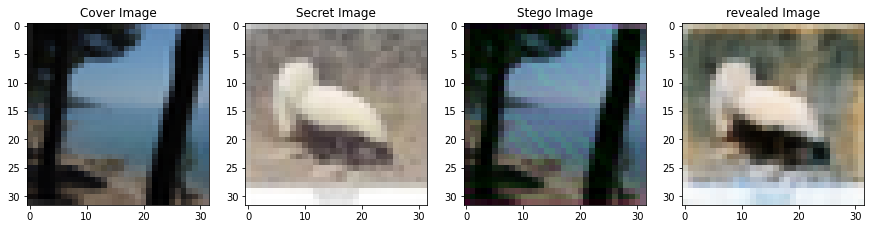

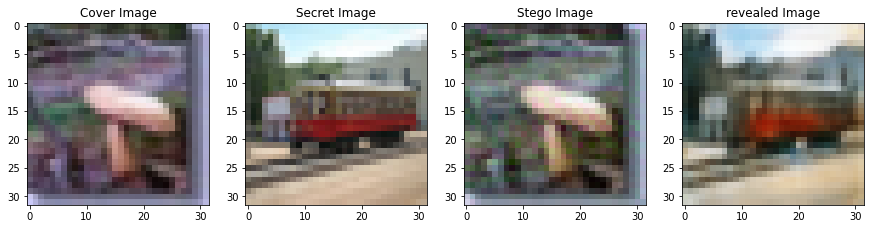

In [ ]:
############# Visual & Quantative evaluation ###############

############# here we use our test images to evaluate our network #############

MSE = DecoderLoss()

for batch_i, (inputs, _) in enumerate(test_loader):
  x=inputs
  break

c1 = torch.cat((x[10],x[11]),0)  # test images have been selected randomly
c2 = torch.cat((x[3],x[12]),0)

c_reshape1=torch.reshape(c1,(1,6,32,32))
c_reshape2=torch.reshape(c2,(1,6,32,32))
stego1,revealed1=mysaved_model.forward(c_reshape1)
stego2,revealed2=mysaved_model.forward(c_reshape2)
stego_x1=stego1.detach()
stego_x2=stego2.detach()
revealed_x1=revealed1.detach()
revealed_x2=revealed2.detach()
secret1 = torch.reshape(x[11],(1,3,32,32))
secret2 = torch.reshape(x[12],(1,3,32,32))
carrier1 = torch.reshape(x[10],(1,3,32,32))
carrier2 = torch.reshape(x[3],(1,3,32,32))

''' 
Quantative evaluation methods :
    MSE
    PSNR
    SSIM
'''
#### SSIM ###
ssim = StructuralSimilarityIndexMeasure()
ssim_r_s1= ssim(revealed1, secret1)
ssim_r_s2= ssim(revealed2, secret2)
ssim_c_s1= ssim(stego1, carrier1)
ssim_c_s2= ssim(stego2, carrier2)
#### MSE  ###
mse_r_S1 = MSE(revealed1, secret1)
mse_r_S2 = MSE(revealed2, secret2)
mse_c_S1 = MSE(stego1, carrier1)
mse_c_S2 = MSE(stego2, carrier2)
#### PSNR ### 
revealed1_f = tf.image.convert_image_dtype(revealed1.detach().numpy(), tf.float32)
revealed2_f = tf.image.convert_image_dtype(revealed2.detach().numpy(), tf.float32)
secret1_f = tf.image.convert_image_dtype(secret1.detach().numpy(), tf.float32) 
secret2_f = tf.image.convert_image_dtype(secret2.detach().numpy(), tf.float32) 
stego1_f = tf.image.convert_image_dtype(stego1.detach().numpy(), tf.float32)
stego2_f = tf.image.convert_image_dtype(stego2.detach().numpy(), tf.float32)
carrier1_f = tf.image.convert_image_dtype(carrier1.detach().numpy(), tf.float32) 
carrier2_f = tf.image.convert_image_dtype(carrier2.detach().numpy(), tf.float32) 

psnr_r_s1= tf.image.psnr(revealed1_f,secret1_f,max_val=1)
psnr_r_s2= tf.image.psnr(revealed2_f,secret2_f,max_val=1)
psnr_c_s1= tf.image.psnr(stego1_f,carrier1_f,max_val=1)
psnr_c_s2= tf.image.psnr(stego2_f,carrier2_f,max_val=1)

print(f" Carrier vs Stego :: ssim : {ssim_c_s1} , MSE : {mse_c_S1}  , PSNR : {psnr_c_s1} //// Revealed vs Secret :: ssim : {ssim_r_s1} , MSE : {mse_r_S1}  , PSNR : {psnr_r_s1}")
print(f" Carrier vs Stego :: ssim : {ssim_c_s2} , MSE : {mse_c_S2}  , PSNR : {psnr_c_s2} //// Revealed vs Secret :: ssim : {ssim_r_s2} , MSE : {mse_r_S2}  , PSNR : {psnr_r_s2}")

fig, ax = plt.subplots(1,4, figsize =(15,15))
ax[0].imshow(x[10].permute(1,2,0))
ax[1].imshow(x[11].permute(1,2,0))
ax[2].imshow(stego_x1[0].permute(1,2,0))
ax[3].imshow(revealed_x1[0].permute(1,2,0))
ax[0].set_title("Cover Image")
ax[1].set_title("Secret Image")
ax[2].set_title("Stego Image")
ax[3].set_title("revealed Image")
fig, ax = plt.subplots(1,4, figsize =(15,15))
ax[0].imshow(x[3].permute(1,2,0))
ax[1].imshow(x[12].permute(1,2,0))
ax[2].imshow(stego_x2[0].permute(1,2,0))
ax[3].imshow(revealed_x2[0].permute(1,2,0))
ax[0].set_title("Cover Image")
ax[1].set_title("Secret Image")
ax[2].set_title("Stego Image")
ax[3].set_title("revealed Image")